### DECS<->VISA example

Here a demonstration of working with DECS<->VISA from a jupyter notebook is provided.

The general operation is very similar to the `example_client.py` code, but rather than require a terminal be opened to launch `decs_visa.py` we will do it directly from the notebook using a python subprocess.

*Note: When running on Windows, outputs from DECS<->VISA are stored in a `decs_visa.log` file, which will be created in your working directory. If struggling to establish a connection between DECS<->VISA and oi.DECS, check the information captured in the `decs_visa.log` file.*

In [1]:
import time
import subprocess
import platform

decs_visa_path = './decs_visa.py'

# Start the decs_visa subprocess
running_on = platform.platform()
if running_on.startswith("Windows"):
    print(f"Running on {running_on} - start subprocess without PIPEd output")
    subprocess.Popen(["python", decs_visa_path])
else:
    print(f"Running on {running_on} - start subprocess with PIPEd output")
    subprocess.Popen(["python3", decs_visa_path], stdout=subprocess.PIPE)
    
# short delay to allow for the server to open
time.sleep(1)

Running on Linux-6.1.0-28-amd64-x86_64-with-glibc2.36 - start subprocess with PIPEd output


2025-04-02 12:57:39,966 - INFO - OS is: Linux-6.1.0-28-amd64-x86_64-with-glibc2.36
2025-04-02 12:57:39,980 - INFO - DECS<->VISA start up
2025-04-02 12:57:39,984 - INFO - Server listening: localhost:33576
2025-04-02 12:57:39,995 - INFO - WAMP connection made
2025-04-02 12:57:40,001 - INFO - Starting WAMP-CRA authentication on realm 'ucss' as user 'API_Controller_1'
2025-04-02 12:57:40,004 - INFO - Established session: 82
2025-04-02 12:57:40,004 - INFO - Attempt to establish a controlling session
2025-04-02 12:57:40,030 - INFO - Ready to process WAMP RPCs


Once the server is open we can connect to it in the same way as the `client_example.py` code - as that has already worked, we'll skip some of the error checking here for brevity.

In [2]:
import pyvisa as visa

rm = visa.ResourceManager('@py')
decs_visa_server_ip = "localhost"
decs_visa_server_port = "33576"
pyvisa_connection = f"TCPIP0::{decs_visa_server_ip}::{decs_visa_server_port}::SOCKET"
decs_visa = rm.open_resource(pyvisa_connection)
decs_visa.read_termination = "\n"
decs_visa.write_termination = "\n"
decs_visa.chunk_size = 204800
decs_visa.timeout = 10000

try:
    print(decs_visa.query("*IDN?"))
except Exception as e:
    print(e)

Oxford Instruments, oi.DECS, decs-557b01, 1.2.1.5175


2025-04-02 12:57:41,011 - INFO - Server connection: ('127.0.0.1', 37734)


In [3]:
# set field example - this will return a number (the Z-field target value set) 
decs_visa.query("set_MAG_TARGET:0,0,0,3,20,0.3,false")

'3.0'

In [ ]:
# set temperature
decs_visa.query("set_MC_T:0.01")

**NB** If the query above threw and exception you'll need to check the server settings, and the DECS<->VISA logs to determine why...

Assuming the above worked correctly; run a simple loop to pull back some data from the system:

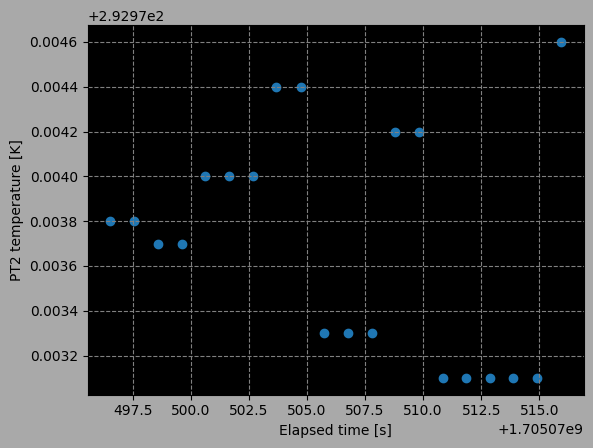

In [3]:
import matplotlib.pyplot as plt

pt2_temps = []
time_stamps = []
for i in range(20):
    time_stamps.append(time.time())
    pt2_temps.append(float(decs_visa.query("get_PT2_T1").strip()))
    time.sleep(1)

fig, ax = plt.subplots()
fig.set_facecolor("darkgrey")
ax.set_facecolor('black')
plt.xlabel(r'Elapsed time [s]')
plt.ylabel(r'PT2 temperature [K]')
plt.grid(visible=True, which = 'major', color = 'grey', linestyle = '--')
plt.scatter(time_stamps, pt2_temps)
plt.show()

We'll want to stop the DECS<->VISA process once we're done, so

In [4]:
decs_visa.write("SHUTDOWN")

2025-04-02 12:59:23,183 - INFO - Socket server shutting down
2025-04-02 12:59:23,184 - INFO - WAMP shutdown request from queue
2025-04-02 12:59:23,185 - INFO - WAMP closing session


9

2025-04-02 12:59:23,195 - INFO - Leaving WAMP session: wamp.error.goodbye_and_out
2025-04-02 12:59:23,788 - INFO - Stopping WAMP event_loop
2025-04-02 12:59:23,790 - INFO - DECS<->VISA stopped
